# Playground

The goal of this project is to generate medical reports from X-ray images. 
The Open-I X-ray image dataset with the corresponding medical reports will be used. The images are in grayscale. We will work on a few so-called *image2text* models. Previous work has explored using RNN with a co-attention mechanism. We'll primarily be exploring transformer models. In self-attention there is no need to extract "tags" as was the case for co-attention. Thus, the model has a larger degree of freedom to learn meaningful representations.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

First the imports.

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models import vgg19, vit_b_16, ViT_B_16_Weights
from torchvision.transforms import Normalize

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

import spacy
#!python -m spacy download en_core_web_lg

import stanza

from utils import *
from dataset import *
from plots import *
from models import *
from nlp import *

fix_seed()

stanza.download("en")

c:\Users\rasmu\anaconda3\envs\xray\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
11:40:34 - INFO: Downloading default packages for language: en (English) ...
11:40:37 - INFO: File exists: C:\Users\rasmu\stanza_resources\en\default.zip
11:40:46 - INFO: Finished downloading models and saved to C:\Users\rasmu\stanza_resources.


## Load data

Let's load the metadata and the images.

In [3]:
REPORT_PATH = "./data/raw/reports"
IMAGE_PATH = "./data/raw/images"

In [4]:
metadata = load_metadata(REPORT_PATH)

11:40:49 - INFO: found 3955 reports.


In [5]:
metadata = load_metadata(REPORT_PATH)
metadata = shuffle_metadata(metadata, seed=42)
metadata.describe()

11:40:56 - INFO: found 3955 reports.


,patient_id
count,7470.000000
mean,1982.730388
std,1143.190929
min,0.000000
25%,994.000000
50%,1988.500000
75%,2969.750000
max,3954.000000


Notice, some of the text is censored by replacing words with "XXXX".

The feature "findings" describes the radiologists observations. While "impression" is the final diagnosis / conclusion.
Let's define a report as the concatation of the findings and impression text.

In [6]:
reports = prepare_reports(metadata)
reports.head()

11:41:01 - INFO: raw report length: 7470
11:41:01 - INFO: post-processing report length: 7430


0    The lungs are clear. There is no pleural effus...
1    The lungs are clear. There is no pleural effus...
2    The left and right XXXX remain enlarged and un...
3    Heart size and mediastinal contours are within...
4    Heart size and mediastinal contours are within...
Name: report, dtype: object

In [7]:
reports.describe()

count                                                  7430
unique                                                 3066
top       The heart is normal in size. The mediastinum i...
freq                                                     96
Name: report, dtype: object

Let's load the images. The images have been cropped such that the width and height are the same. Afterwards, the images have been downscaled to 224x224. 

In [52]:
# we'll only use a subset of the dataset in the *notebook* due to memory constraints. However, the scripts will use the full dataset.
N = 100
offset = 6000 # use an offset so all these images correspond to the test dataset using by the trained model

metadata_subset = metadata[offset:offset+N]
reports_subset = prepare_reports(metadata_subset)

images = load_images(metadata_subset, IMAGE_PATH, resized=(224, 224))

11:52:45 - INFO: raw report length: 100
11:52:45 - INFO: post-processing report length: 100


There are images from two views: frontal and lateral. It may be worth to include this information in the model. However, since the view hasn't already been annotated, we will ignore it for now.

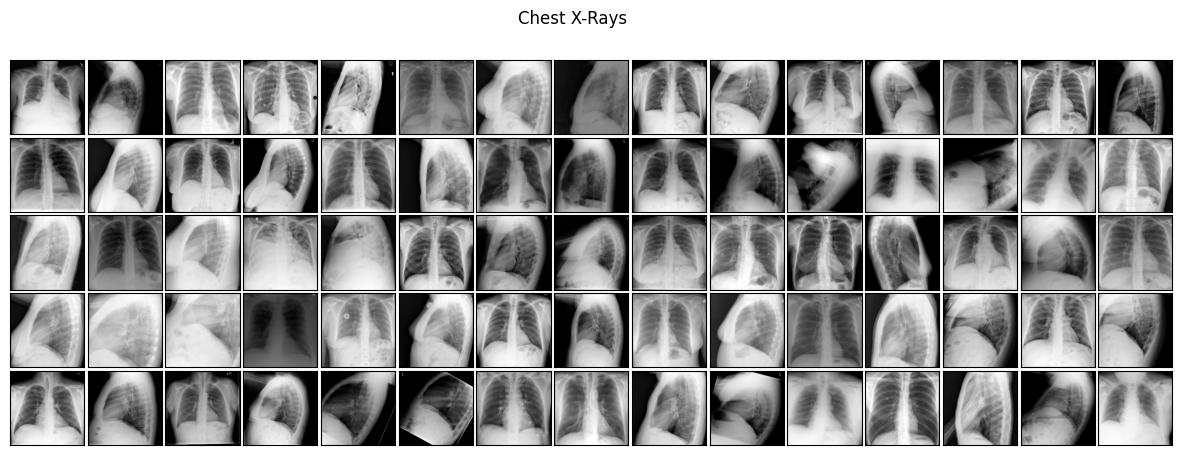

In [9]:
offset = 0
n_rows = 5
n_cols = 15

images_tiny = images[offset:offset+n_rows*n_cols]

plot_images_2d(images_tiny.reshape(n_rows, n_cols, *images_tiny.shape[1:]), "Chest X-Rays")

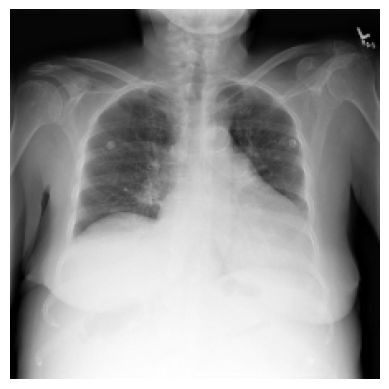

In [10]:
highlighted_image = images[0]
plot_image(highlighted_image)

Time to plot a few random X-ray image and their corresponding reports!

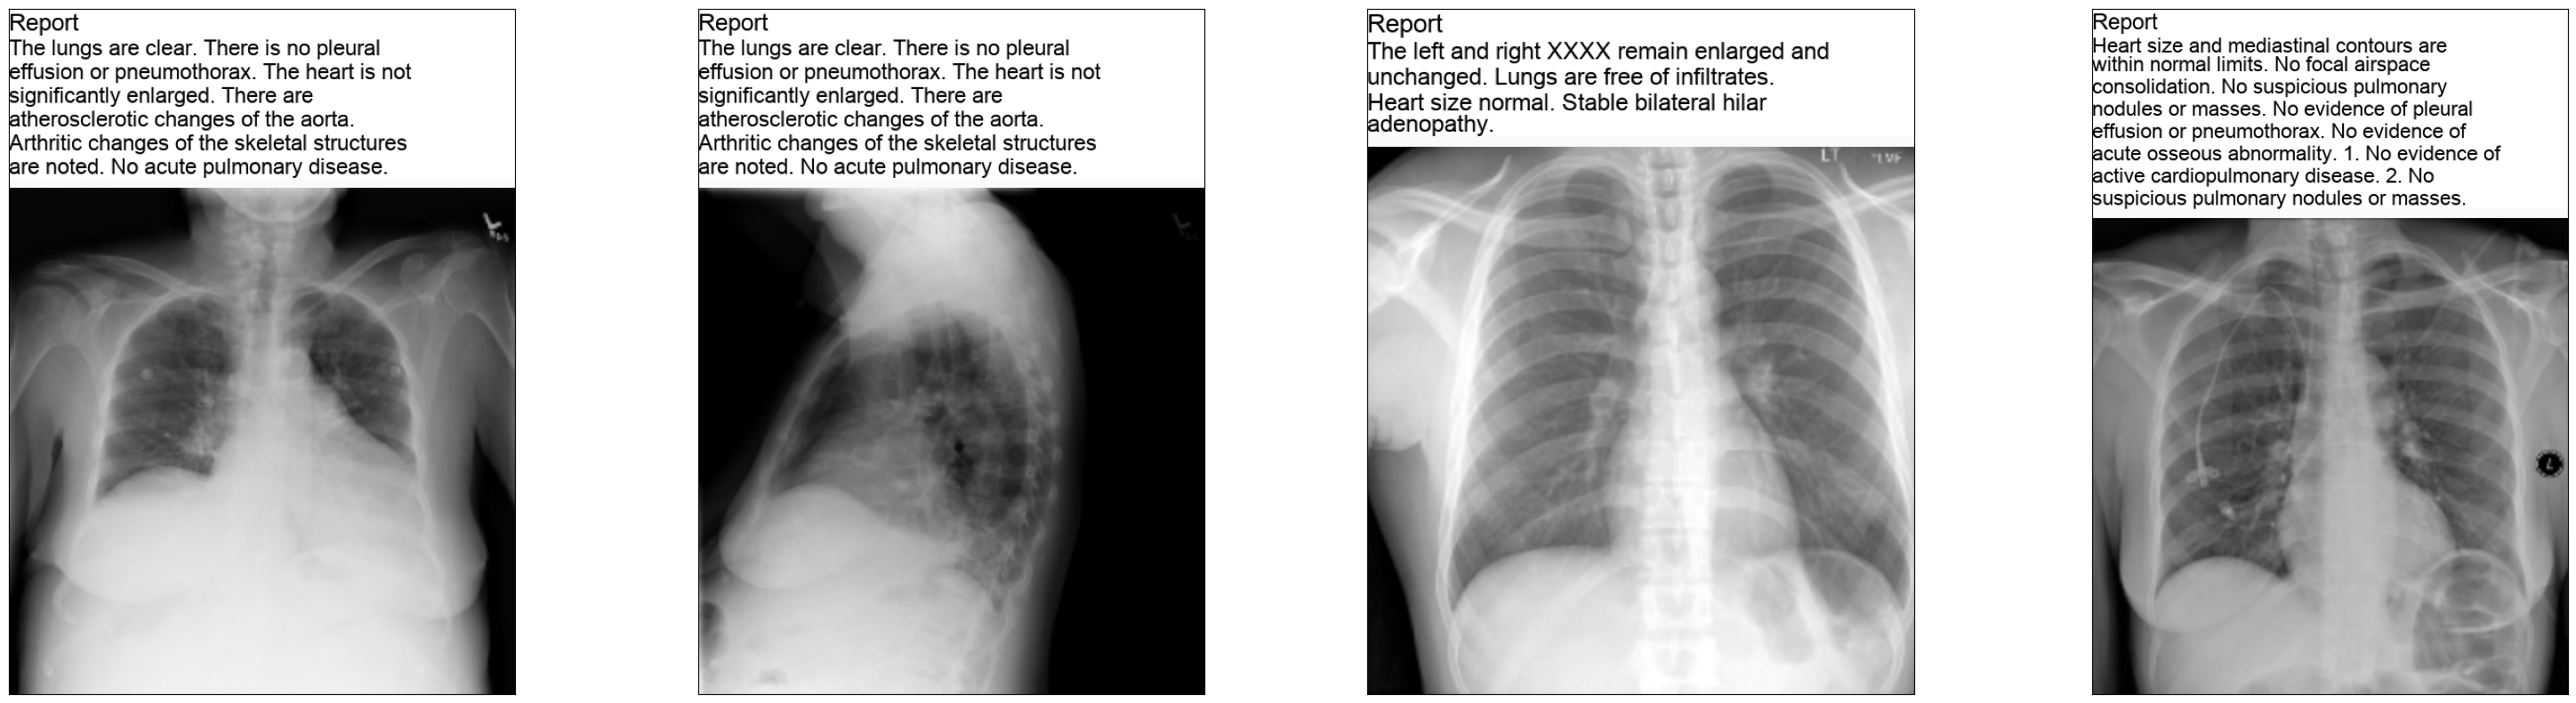

In [11]:
k = np.arange(4) #1400

title = "Report"
extracted_textbodies = reports.iloc[k]
extracted_images = images[k].numpy()

plot_multiple_text_and_images(extracted_textbodies, title, extracted_images)

## Preprocessing

### Images

Images are already normalized the range [0, 1]. The models may also do some more prepocessing of the images as some of them are pretrained model. Preprocessing includes z-score normalization. 

### Text

Let's tokenize the reports.

In [12]:
#tokenizer = spacy_tokenizer()
tokenizer = stanza_tokenizer()

tokenized_reports = reports.apply(lambda text : tokenize(text, tokenizer))

11:41:14 - INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
11:41:14 - INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

11:41:14 - INFO: Using device: cpu
11:41:14 - INFO: Loading: tokenize
11:41:14 - INFO: Done loading processors!


And time for some statistics:

In [13]:
tokenized_reports.head()

0    [the, lungs, are, clear, ., there, is, no, ple...
1    [the, lungs, are, clear, ., there, is, no, ple...
2    [the, left, and, right, remain, enlarged, and,...
3    [heart, size, and, mediastinal, contours, are,...
4    [heart, size, and, mediastinal, contours, are,...
Name: report, dtype: object

In [14]:
tokenized_reports_lengths = tokenized_reports.apply(len)

print(f"Report length: {np.mean(tokenized_reports_lengths):.1f} +- {np.std(tokenized_reports_lengths):.1f} words.")
print(f"Report length boundaries: [{np.min(tokenized_reports_lengths):.1f}; {np.max(tokenized_reports_lengths):.1f}] words.")

Report length: 42.5 +- 21.0 words.
Report length boundaries: [3.0; 248.0] words.


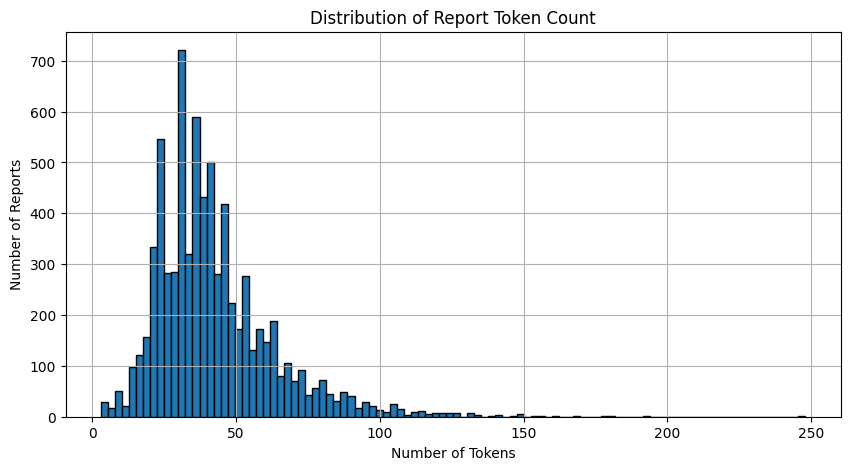

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(tokenized_reports_lengths, bins=100, histtype="bar", ec="black")
ax.set_title("Distribution of Report Token Count")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Number of Reports")
ax.grid()
plt.show()

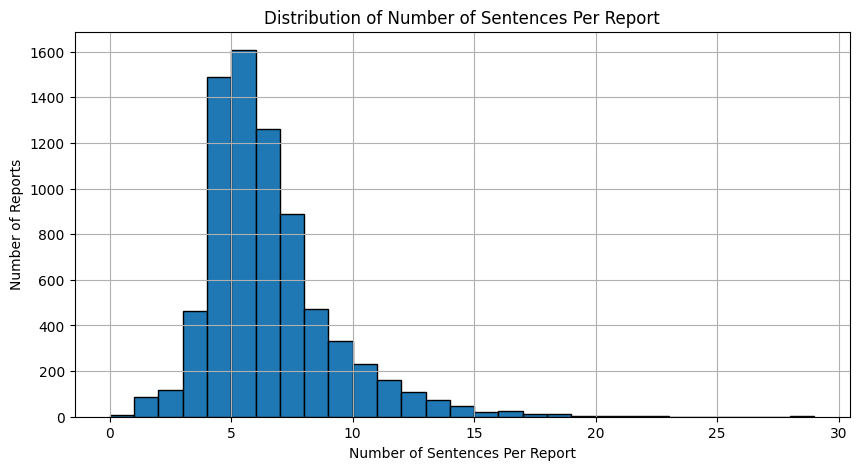

In [16]:
sentences = []
for token_ids in tokenized_reports:
    n_sentences = np.sum([1 for token in token_ids if token == "."])
    sentences.append(n_sentences)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(sentences, bins=max(sentences), histtype="bar", ec="black")
ax.set_title("Distribution of Number of Sentences Per Report")
ax.set_xlabel("Number of Sentences Per Report")
ax.set_ylabel("Number of Reports")
ax.grid()
plt.show()

In [17]:
print(f"Number of sentences: {np.mean(sentences):.1f} +- {np.std(sentences):.1f} sentences.")
print(f"Number of sentences boundaries: [{np.min(sentences):.1f}; {np.max(sentences):.1f}] sentences.")

Number of sentences: 6.0 +- 2.6 sentences.
Number of sentences boundaries: [0.0; 29.0] sentences.


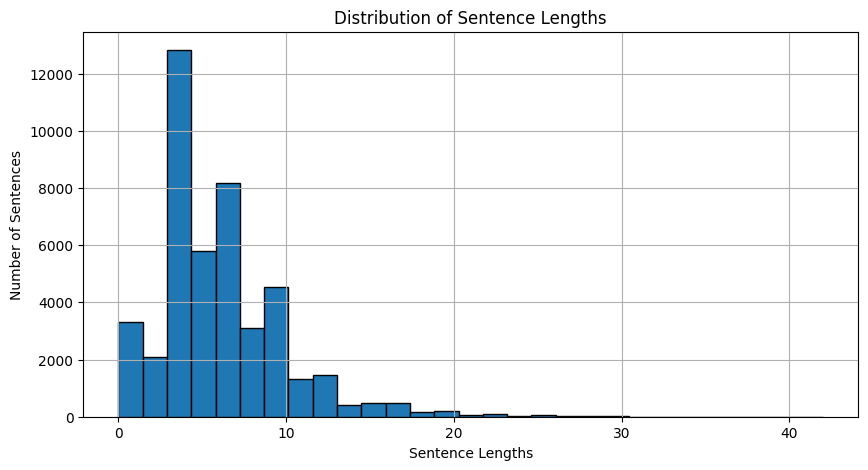

In [18]:
sentence_lengths = []
for token_ids in tokenized_reports:
    sentence_length = 0
    for token in token_ids:
        if token == ".":
            sentence_lengths.append(sentence_length)
            sentence_length = 0
        else:
            sentence_length += 1


fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(sentence_lengths, bins=max(sentences), histtype="bar", ec="black")
ax.set_title("Distribution of Sentence Lengths")
ax.set_xlabel("Sentence Lengths")
ax.set_ylabel("Number of Sentences")
ax.grid()
plt.show()

Let's look at the most common words in the reports.

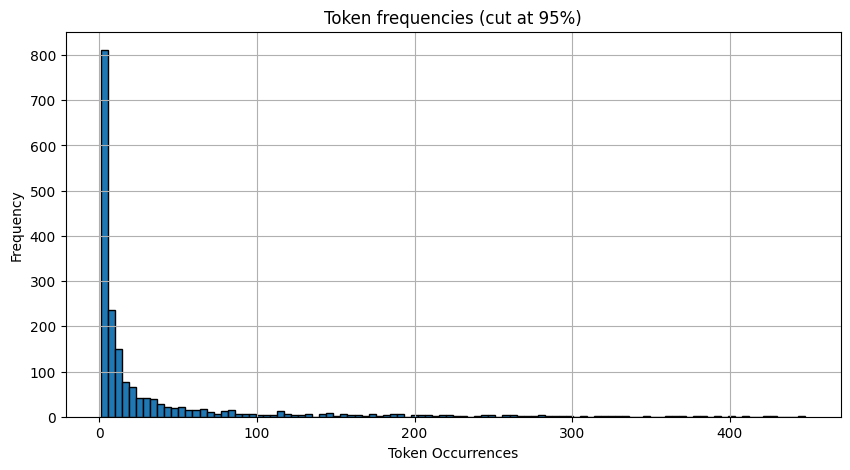

In [19]:
token_counts = count_token_occurences(tokenized_reports)

token_frequencies = [token_counts[token_id] for token_id in token_counts]
token_frequencies.sort(reverse=True)

cut_percent = 0.95
cut = (int)(len(token_frequencies)*(1-cut_percent))
token_frequencies = token_frequencies[cut:]
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(token_frequencies, bins=100, histtype="bar", ec="black")
ax.set_title(f"Token frequencies (cut at {cut_percent*100:.0f}%)")
ax.set_xlabel("Token Occurrences")
ax.set_ylabel("Frequency")
ax.grid()
plt.show()

Our dataset is small, and since most of the words are very infrequent, we will be using pre-trained embeddings.

Let's see the most frequent tokens:

In [20]:
token_ids = [token_id for token_id in token_counts]
token_ids.sort(key=lambda token_id : token_counts[token_id], reverse=True)

N = 20

for token in token_ids[:N]:
    print(f"{token} ({token_counts[token]})")

. (44679)
no (14553)
the (13438)
is (8946)
are (8761)
normal (7720)
of (6426)
and (6412)
acute (5818)
pleural (5430)
or (5427)
pneumothorax (4896)
effusion (4793)
there (4744)
heart (4732)
lungs (4528)
size (4304)
focal (3663)
clear (3608)
pulmonary (3237)


and the size of the vocabulary...

In [21]:
vocabulary = build_vocabulary([token for tokens in tokenized_reports for token in tokens])
print(f"vocabulary size: {len(vocabulary)} tokens")

token2id, id2token = map_token_and_id(vocabulary)

vocabulary size: 1932 tokens


## Models

Time for training...
First let's load the pretrained embeddings, trained on a medical dataset.

In [22]:
vectors, embed_dim = load_pubmed_embeddings_IU_xray_pretrained()
#vectors, embed_dim = load_bundled_glove_embeddings()
word_embeddings = prepare_word_embeddings(token2id, vectors, embed_dim)

unknown_tokens_embeddings = [token for token in vocabulary if token not in vectors]
print(f"Number of tokens not in word embeddings: {len(unknown_tokens_embeddings)}")

Number of tokens not in word embeddings: 5


In [23]:
unknown_tokens_embeddings[:5]

['v', 'nlarged', '.', '<PAD>', 'mergent']

Let's define the dataset splits.

In [53]:
"""
model_name = "playground"
model = XRayPlaygroundModel(len(vocabulary))

model_name = "vit"
model = XRayViTModel(word_embeddings)


model_name = "chex1"
model = CheXNet1(word_embeddings)
"""

model_name = "chex2"
model = CheXTransformerNet(word_embeddings)


images_ready = model.preprocess(images)

train_test_split = .9
train_validation_split = .9

size = len(images)
size = 10

total_train_size = int(size * train_test_split)
train_size = int(total_train_size * train_validation_split)
train_end = size+1

train_dataset = XRayDataset(images_ready[:train_size], tokenized_reports[:train_size], token2id)
validation_dataset = XRayDataset(images_ready[train_size:total_train_size], tokenized_reports[train_size:total_train_size], token2id)
test_dataset = XRayDataset(images_ready[total_train_size:train_end], tokenized_reports[total_train_size:train_end], token2id)

11:53:10 - INFO: processing images: 0/100
11:53:13 - INFO: processing images: 16/100
11:53:17 - INFO: processing images: 32/100
11:53:20 - INFO: processing images: 48/100
11:53:24 - INFO: processing images: 64/100
11:53:27 - INFO: processing images: 80/100
11:53:31 - INFO: processing images: 96/100


In [ ]:
train(model_name, model, vocabulary, train_dataset, validation_dataset, epochs=20, batch_size=16, optimizer=optim.Adam(model.parameters(), lr=0.001), disable_tqdm=False)

Actually, the model is already trained. Let's load the weights and evalulate the performance.

In [94]:
result = load_dict(os.path.join("results", model_name, "train_result.pkl"))

train_losses = result["train_losses"]
validation_losses = result["validation_losses"]
validation_bleus = result["validation_bleu"]

train_loss = train_losses[-1]
validation_loss = validation_losses[-1]

accuracy = lambda loss: np.exp(-loss)
perplexity = lambda loss: np.exp(loss)

loss_random = -np.log(1 / len(vocabulary))

tokens_counts_np = np.array(list(token_counts.values()))
loss_base = -np.log(tokens_counts_np.max() / tokens_counts_np.sum())

print(f"loss | train: {train_loss:.3f}, validation: {validation_loss:.3f}, random: {loss_random:.3f}, base: {loss_base:.3f}")
print(f"perplexity | train: {perplexity(train_loss):.3f}, validation: {perplexity(validation_loss):.3f}, random: {perplexity(loss_random):.3f}, base: {perplexity(loss_base):.3f}")
print(f"accuracy | train: {accuracy(train_loss):.4f}, validation: {accuracy(validation_loss):.4f}, random: {accuracy(loss_random):.4f}, base: {accuracy(loss_base):.4f}")

loss | train: 0.051, validation: 8.760, random: 7.566, base: 1.956
perplexity | train: 1.052, validation: 6373.657, random: 1932.000, base: 7.069
accuracy | train: 0.9503, validation: 0.0002, random: 0.0005, base: 0.1415


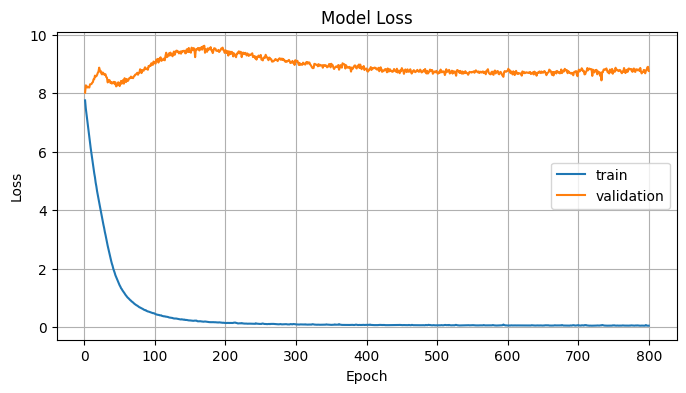

In [93]:
plot_losses(train_losses, validation_losses)

The model doesn't appear to learn the underlying distribution of the data, as the validation loss doesn't decreases over time.

## Evaluation

Time to generate some reports!

In [54]:
model.load_state_dict(torch.load(os.path.join("models", model_name, "model.pt"), map_location=torch.device("cpu")))

<All keys matched successfully>

true:  <START> there are scattered calcified granulomas. no focal infiltrate. no pleural effusion or pneumothorax. heart size and mediastinal contour are within normal limits. there are degenerative changes of the spine. no evidence of active disease. <END>
guess: <START> both lungs remain clear and expanded area normal heart and mediastinum normal present around the caval atrial junction. incidental note that suggestive of bilateral breast implants obscure some kyphosis noted in the lower thoracic spine fusion intact. no active cardiopulmonary process. <END>


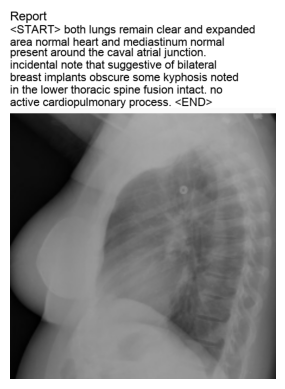

In [87]:
sample_idx = 6
x, report_ids, _ = train_dataset[sample_idx]

target = [id2token[token] for token in report_ids]

generated_ids = prob_sample(model, x, token2id, max_length=100)
generated = [id2token[token] for token in generated_ids]

report = tokens_to_text(target)
report_est = tokens_to_text(generated)

print(f"true:  {report}")
print(f"guess: {report_est}")

xray_plotable = images[sample_idx].numpy()
plot_text_and_image(report_est, "Report", xray_plotable)

Let's also use beam search to generate multiple reports and see how they compare to the ground truth.

In [88]:
beams = beam_search(model, x, token2id, beam_width=5, max_length=75)

for beam in beams:
    print(tokens_to_text([id2token[id] for id in beam[1]]))

<START> both lungs are clear and expanded area heart and mediastinum normal. incidental note of bilateral breast implants obscure a tortuous ectatic aorta. <END>
<START> both lungs are clear and expanded area heart and mediastinum normal. incidental note of bilateral breast implants obscure a tortuous ectatic aorta. no active disease <END>
<START> both lungs are clear and expanded area heart and mediastinum normal. incidental note of bilateral breast implants obscure a tortuous ectatic aorta. no active disease. <END>
<START> both lungs are clear and expanded area has its heart and mediastinum normal. incidental note of bilateral breast implants obscure a tortuous ectatic aorta. an aortic aneurysm cannot exclude ascending aorta. <END>
<START> both lungs are clear and expanded area has its heart and mediastinum normal. incidental note of bilateral breast implants obscure a tortuous ectatic aorta. an aortic aneurysm cannot exclude ascending aorta is not excluded on this study chest film w

Notice, how similiar the generated reports are.

Let's explore where the transformer model puts it attention on the image. 

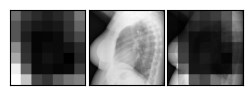

In [89]:
_, = model(torch.tensor(report_ids)[None], x[None])

attn_context_token = model.decoder.decoder_layer1.multihead_attn_weights
attn_context = attn_context_token.squeeze(0).mean(dim=0)

image_attention_mask = create_image_attention_mask(attn_context.detach().numpy(), xray_plotable.shape, (7, 7))#, interpolation=cv2.INTER_CUBIC)
plot_images(np.array([image_attention_mask, xray_plotable, image_attention_mask * xray_plotable]))

This is not great. The attention is not really focused on the image. The model is not learning anything useful - just as we expected from the validation loss.

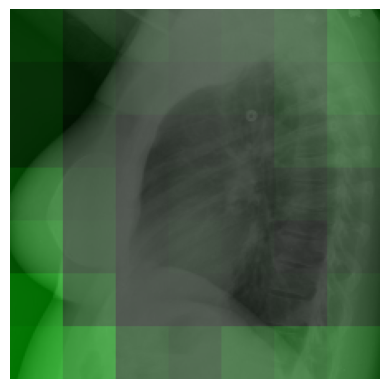

In [91]:
img1 = overlay_attention(xray_plotable, image_attention_mask)
plot_image_multichannel(img1)

In [37]:
references, candidates = prepare_for_evaluation(model, train_dataset, token2id, id2token, early_exit=10)
            
# get some feedback during training
for i in range(len(references)):
    example_truth = references[i][0]
    example_prediction = candidates[i]

    logging.info("True and predicted report:")
    logging.info(f"true: {tokens_to_text(example_truth)}")
    logging.info(f"pred: {tokens_to_text(example_prediction)}")
    logging.info("")

11:46:52 - INFO: passing sample 0/8
11:47:32 - INFO: True and predicted report:
11:47:32 - INFO: true: the lungs are clear. there is no pleural effusion or pneumothorax. the heart is not significantly enlarged. there are atherosclerotic changes of the aorta. arthritic changes of the skeletal structures are noted. no acute pulmonary disease.
11:47:32 - INFO: pred: mild cardiomegaly densely calcified aorta. prominence of pulmonary outflow tract indicates enlarged pulmonary arteries hypertension. no overt edema or effusions. elevated right diaphragm eventration of right diaphragm eventration of right diaphragm eventration of right hemidiaphragm elevation with right diaphragm eventration of right diaphragm eventration of right diaphragm eventration of right diaphragm. question very small left basilar atelectasis versus infiltrate versus infiltrate versus infiltrate versus inspiratory with tip at cavoatrial junction without overt pulmonary artery hypertension.
11:47:32 - INFO: 
11:47:32 - I

That was it. There is also source code a hierachical RNN, which performs better, but we ignored it here, since we were more interested in transformer-based models. Next time it would be a good idea to use a larger dataset, since it appears as if the transformer model doesn't generalize to the task. The MIMIC-CXR dataset is significantly larger.
In conclusion, transformer models need large amount of data, even if we use a pretrained encoder and pretrained embeddings. RNN-based model are unreasonable effective even for smaller dataset.